In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.modules import ReLU,Linear,Dropout

## VGG19

model architecture :

<!-- ![Sample Image](Pics/map.PNG) -->
<div style="text-align:center">
  <img src="Pic/vgg19.png" alt="alt text" style="width:70%;"/>
</div>

In [ ]:
vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 56.1MB/s]


### Load dataset (SIFAR-10)

In [ ]:
# Define the transformer
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to fit VGG19 input size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
])

# Load the CIFAR-10 dataset
cifar10_dataset_train = datasets.CIFAR10(root='./data', train=True,
                                   download=True, transform=transform)

cifar10_dataset_test = datasets.CIFAR10(root='./data', train=False,
                                   download=True, transform=transform)

# Filter the dataset to include only the first two classes
class_indices = [0, 1]
filtered_training_dataset = torch.utils.data.Subset(cifar10_dataset_train,
                                               [i for i in range(len(cifar10_dataset_train)) if cifar10_dataset_train.targets[i] in class_indices])

filtered_testing_dataset = torch.utils.data.Subset(cifar10_dataset_test,
                                               [i for i in range(len(cifar10_dataset_test)) if cifar10_dataset_test.targets[i] in class_indices])


# Create a data loader
train_data_loader = DataLoader(filtered_training_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(filtered_testing_dataset, batch_size=64, shuffle=True)


100%|██████████| 170498071/170498071 [00:03<00:00, 49236331.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = cifar10_dataset_train.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

label 0  >>  airplane

label 1  >>  automobile

  0%|          | 0/157 [00:00<?, ?it/s]


class = airplane


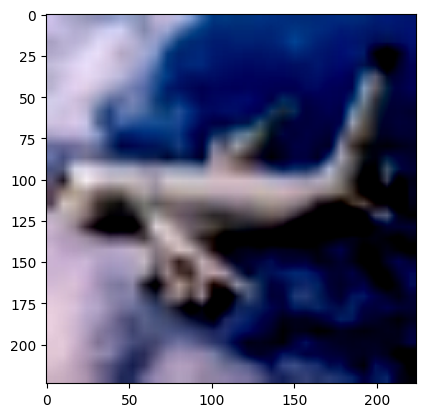

In [ ]:
for (data, targets) in tqdm(train_data_loader):
    index = 0
    plt.imshow(data[index].numpy().transpose(1, 2, 0))
    print(f'class = {classes[targets[index]]}')
    break

model architecture (before modifing):

In [ ]:
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
vgg19.classifier  # defualt classfier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Freeze all parameters of model:

In [ ]:
for param in vgg19.parameters():
    param.requires_grad = False

In [ ]:
my_classifier = torch.nn.Sequential(
    Linear(in_features=25088, out_features=4096, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=4096, out_features=2048, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=2048, out_features=2, bias=True),
)

vgg19.classifier = my_classifier

model architecture (after modifing):

In [ ]:
vgg19 = vgg19.cuda()
print(vgg19.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=2048, out_features=2, bias=True)
)


In [ ]:
for name, param in vgg19.named_parameters():
    if param.requires_grad:
        print(f"The layer '{name}' is not frozen.")

The layer 'classifier.0.weight' is not frozen.
The layer 'classifier.0.bias' is not frozen.
The layer 'classifier.3.weight' is not frozen.
The layer 'classifier.3.bias' is not frozen.
The layer 'classifier.6.weight' is not frozen.
The layer 'classifier.6.bias' is not frozen.


In [ ]:
for (data, targets) in tqdm(train_data_loader):
    print(vgg19(data.cuda()).shape)
    break

  0%|          | 0/157 [00:01<?, ?it/s]

torch.Size([64, 2])


## train network

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=0.01)
num_epochs = 25

losses = []
accuracies = []

for _epoch in range(num_epochs):
    epoch_loss = 0
    train_acc = 0
    for (data, targets) in tqdm(train_data_loader):
        data = data.cuda()
        targets = targets.cuda()

        optimizer.zero_grad()
        outputs = vgg19(data)
        loss = criterion(outputs, targets)

        _, predicted_train = torch.max(outputs, 1)
        train_acc += (predicted_train == targets).sum().item() / len(targets)

        epoch_loss += loss
        loss.backward()
        optimizer.step()

    print(f'loss @ epoch {_epoch}: {epoch_loss}')
    print('train accuracy: ',(train_acc/len(train_data_loader))*100)
    losses.append(epoch_loss)
    accuracies.append((train_acc/len(train_data_loader))*100)




100%|██████████| 157/157 [01:14<00:00,  2.09it/s]


loss @ epoch 0: 6831.7666015625
train accuracy:  93.531050955414


100%|██████████| 157/157 [01:19<00:00,  1.98it/s]


loss @ epoch 1: 78.17481231689453
train accuracy:  97.74084394904459


100%|██████████| 157/157 [01:15<00:00,  2.08it/s]


loss @ epoch 2: 55.61654281616211
train accuracy:  98.14888535031847


100%|██████████| 157/157 [01:16<00:00,  2.05it/s]


loss @ epoch 3: 142.35316467285156
train accuracy:  97.81050955414013


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 4: 327.5936279296875
train accuracy:  97.38256369426752


100%|██████████| 157/157 [01:14<00:00,  2.09it/s]


loss @ epoch 5: 1216.7808837890625
train accuracy:  96.92476114649682


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 6: 3261.510009765625
train accuracy:  97.11385350318471


100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


loss @ epoch 7: 3884.081787109375
train accuracy:  97.9000796178344


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 8: 1706.72802734375
train accuracy:  98.60668789808918


100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


loss @ epoch 9: 3084.929443359375
train accuracy:  98.57683121019109


100%|██████████| 157/157 [01:14<00:00,  2.09it/s]


loss @ epoch 10: 3058.65771484375
train accuracy:  98.74601910828027


100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


loss @ epoch 11: 2094.088623046875
train accuracy:  98.99482484076432


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 12: 1533.528564453125
train accuracy:  99.36305732484077


100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


loss @ epoch 13: 2388.226806640625
train accuracy:  99.1640127388535


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 14: 3079.11328125
train accuracy:  99.29339171974523


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 15: 1939.731201171875
train accuracy:  99.44267515923568


100%|██████████| 157/157 [01:14<00:00,  2.09it/s]


loss @ epoch 16: 1572.4332275390625
train accuracy:  99.41281847133759


100%|██████████| 157/157 [01:14<00:00,  2.09it/s]


loss @ epoch 17: 1098.644287109375
train accuracy:  99.47253184713377


100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


loss @ epoch 18: 964.23486328125
train accuracy:  99.66162420382165


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 19: 1315.0482177734375
train accuracy:  99.44267515923568


100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


loss @ epoch 20: 970.4202270507812
train accuracy:  99.60191082802548


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 21: 1575.5689697265625
train accuracy:  99.48248407643312


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


loss @ epoch 22: 1902.3719482421875
train accuracy:  99.5421974522293


100%|██████████| 157/157 [01:14<00:00,  2.09it/s]


loss @ epoch 23: 1555.3148193359375
train accuracy:  99.52229299363057


100%|██████████| 157/157 [01:14<00:00,  2.10it/s]

loss @ epoch 24: 1933.3775634765625
train accuracy:  99.65167197452229


### train & test accurracy

In [ ]:
with torch.no_grad():
    train_accuracy = 0
    for (data, targets) in tqdm(train_data_loader):
        data = data.cuda()
        targets = targets.cuda()
        train_outputs = vgg19(data)
        _, predicted_train = torch.max(train_outputs, 1)
        train_accuracy += (predicted_train == targets).sum().item() / len(targets)
        # print(predicted_train)

print('train accuracy: ',(train_accuracy/len(train_data_loader))*100)

100%|██████████| 157/157 [01:14<00:00,  2.10it/s]

train accuracy:  99.67157643312102


In [ ]:
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_data_loader):
        data = data.cuda()
        targets = targets.cuda()
        test_outputs = vgg19(data)
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy += (predicted_test == targets).sum().item() / len(targets)

print('test accuracy: ',(test_accuracy/len(test_data_loader))*100)

100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

test accuracy:  98.4375


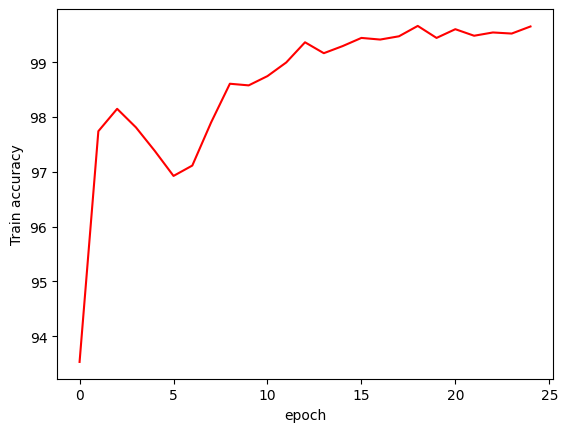

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracies,'r') ;
plt.xlabel('epoch')
plt.ylabel('Train accuracy');

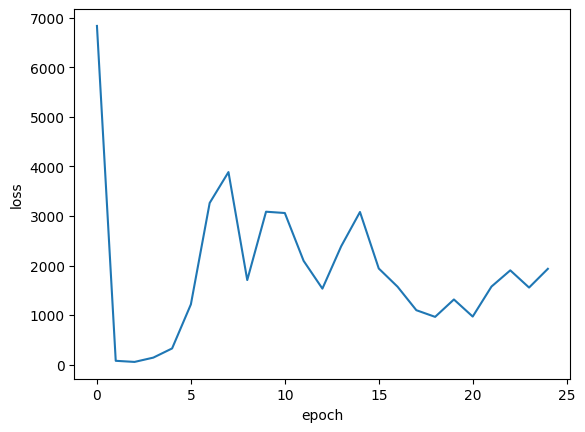

In [ ]:
x = []
for i in losses:
  x.append(i.cpu().detach().numpy())

plt.plot(x)
plt.xlabel('epoch')
plt.ylabel('loss');

Save the model :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(vgg19.state_dict(), '/content/drive/My Drive/DEEP/HW3/Q1/q1_model1.pth')

---